In [1]:
# these are our created files
from train import fit 
from datasets import MNIST_Test, MNIST_Train_Datasource
from predict import predict_and_save

# additional packages
import os
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load & Explore Data

In [3]:
# paths
ROOT_DIR = os.path.join('..', 'datasets', 'MixedMNIST', '') # ../datasets/MixedMNIST/
IMAGES_DIR = os.path.join(ROOT_DIR, 'images', '') # ../datasets/MixedMNIST/images/
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, 'train', '')
TEST_IMAGES_DIR = os.path.join(IMAGES_DIR, 'test', '')

# csv files
TRAIN_CSV = ROOT_DIR + 'train.csv'
TRAIN_CSV_PROCESSED = ROOT_DIR + 'train_processed.csv' # this file will have the datasource label split in a separate column
TEST_CSV = ROOT_DIR + 'test.csv'

## 1.1 Train Data
- ``ImageFolder`` loads images from a directory where each subdirectory will be interpreted as a class/label
https://pytorch.org/vision/stable/datasets.html
```
images_train
└───0
│   │   0_003008.png
│   │   1_231516.png
│   │   ...
.
.
.
└───9
│   │   0_031433.png
│   │   1_208115.png
│   │   ...
```

In [4]:
mnist_train = ImageFolder(
    TRAIN_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)

Show recognized classes

In [5]:
print(mnist_train.class_to_idx)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


``ImageFolder`` stores the full path to the image (among other informations)

In [6]:
img_names = [x[0] for x in mnist_train.imgs]
img_names


['../datasets/MixedMNIST/images/train/0/0_000013.png',
 '../datasets/MixedMNIST/images/train/0/0_000035.png',
 '../datasets/MixedMNIST/images/train/0/0_000044.png',
 '../datasets/MixedMNIST/images/train/0/0_000060.png',
 '../datasets/MixedMNIST/images/train/0/0_000149.png',
 '../datasets/MixedMNIST/images/train/0/0_000165.png',
 '../datasets/MixedMNIST/images/train/0/0_000175.png',
 '../datasets/MixedMNIST/images/train/0/0_000232.png',
 '../datasets/MixedMNIST/images/train/0/0_000251.png',
 '../datasets/MixedMNIST/images/train/0/0_000260.png',
 '../datasets/MixedMNIST/images/train/0/0_000326.png',
 '../datasets/MixedMNIST/images/train/0/0_000390.png',
 '../datasets/MixedMNIST/images/train/0/0_000417.png',
 '../datasets/MixedMNIST/images/train/0/0_000481.png',
 '../datasets/MixedMNIST/images/train/0/0_000554.png',
 '../datasets/MixedMNIST/images/train/0/0_000606.png',
 '../datasets/MixedMNIST/images/train/0/0_000677.png',
 '../datasets/MixedMNIST/images/train/0/0_000679.png',
 '../datas

Make sure the dataset has correct size and the images the correct shape

In [7]:
print(mnist_train[0][0].shape)
print(len(mnist_train))


torch.Size([1, 28, 28])
240000


## 1.2 Train Data with ``datasource`` as label

This custom dataset is the same as above with the difference that each image has the ``datasource`` as label. <br>
Create a test dataset object and perform grayscale + ToTensor transformation. <br>
sample: ``image``, ``datasource``

In [8]:
mnist_train_datasource = MNIST_Train_Datasource(
    csv_file_processed=TRAIN_CSV_PROCESSED,
    csv_file=TRAIN_CSV,
    img_dir=TRAIN_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)


In [9]:
print(mnist_train_datasource[0][0].shape)
print(len(mnist_train_datasource))


torch.Size([1, 28, 28])
240000


Plot some images with their ``datasource`` label

<Figure size 432x288 with 0 Axes>

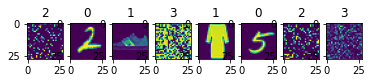

In [10]:
plt.figure()
f, axarr = plt.subplots(1, 8)
for i in range(8):
    image, label = mnist_train_datasource[i]
    axarr[i].imshow(image[0])
    axarr[i].set_title(label)


## 1.3 Test Data
- Since the test images are not structured in subfolders and don't have any indication of their class, we can not use ``ImageFolder``
```
images_test
│   003008.png
│   231516.png
│   069583.png
...
```
sample: ``image``, ``image id``

In [11]:
mnist_test = MNIST_Test(
    csv_file=TEST_CSV,
    img_dir=TEST_IMAGES_DIR,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ]
    )
)


In [12]:
print(mnist_test[0][0].shape)
print(len(mnist_test))


torch.Size([1, 28, 28])
40000


We can simply get all information by calling the ``mnist_test`` attributes

In [13]:
mnist_test.csv.image


0        240000.png
1        240001.png
2        240002.png
3        240003.png
4        240004.png
            ...    
39995    279995.png
39996    279996.png
39997    279997.png
39998    279998.png
39999    279999.png
Name: image, Length: 40000, dtype: object

... or the information for a single image, e.g. the ``image_id``

In [14]:
mnist_test[0][1]


240000

# 2. Model definitions
Our goal is to train 3 different networks and to compare their results. <br>

**2x Multiclass classifiers** <br>
Since we only need to predict the ``class`` label for each image in the give test dataset, we will train 2 multiclass classifiers (ignoring the fact that we have an additional label ``datasource``). Another reason to follow this *naive* approach is because we have a lot of samples (240.000 images) and we think this should be enough data to get decent results.
- CNN: The first network would be a relative simple CNN.
- ResNet: The second network would be a ResNet. This should allow us to train more deep networks.

**1x combination of two classifiers** <br>
Our 3rd network will be a combination of two classifiers, one for the ``class`` and one for the ``datasource`` label. The reason for this approach is obviously making use of the additional information given.

## 2.1 CNN
### Reminder:
- Input shape: $n_h\times n_w$
- Kernel shape: $k_h\times k_w$,
- Output shape: $(n_h-k_h+1) \times (n_w-k_w+1)$. Since kernels are usually > 1, the output will be always smaller than input
- Example: Input $240 \times 240$ pixel image, $10$ layers of $5 \times 5$ convolutions = $200 \times 200$ pixel image
- The ``out_channels`` is what convolution will produce so these are the **number of filters**. They are usually choosen by intuition.


In [15]:
# It will produce 3 filters with the shape 4 rows, 5 columns
c = nn.Conv2d(1, 3, stride=1, kernel_size=(4, 5))
print(c.weight.shape)
print(c.weight)

torch.Size([3, 1, 4, 5])
Parameter containing:
tensor([[[[-0.0686,  0.1996,  0.2233,  0.2140, -0.0763],
          [-0.2031,  0.2191,  0.1139, -0.2088,  0.1804],
          [ 0.0863,  0.2158, -0.0780,  0.1455, -0.0689],
          [ 0.1503,  0.0987, -0.1224,  0.0532,  0.1780]]],


        [[[-0.0067, -0.2000, -0.0208,  0.1961,  0.0373],
          [ 0.0669, -0.2002,  0.1887,  0.0129, -0.1056],
          [ 0.0134, -0.0553,  0.1180, -0.1135,  0.0053],
          [ 0.2232, -0.0751, -0.0751, -0.1208, -0.1258]]],


        [[[-0.0497, -0.1521,  0.1706,  0.2213, -0.1890],
          [-0.0076, -0.0804, -0.0783,  0.1256, -0.1605],
          [ 0.1355, -0.1579, -0.1412,  0.0482, -0.0978],
          [-0.1742,  0.1706, -0.0682,  0.0948,  0.0222]]]], requires_grad=True)


### Padding
- Padding can handle this issue and affect the output size
- It adds extra pixels around the boundary of the input image
- padding=1, input=$3\times 3$, kernel_size=2, output=$4 \times 4$
$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$
- **For the kernel size we usually use odd numbers such as 1,3,5,7 to keep the spatial dimensionality while padding.**

### Stride
- Sometimes we want to move our kernel-window more than 1 element
- This has computational or downsample reasons
- The first layer in the ResNet uses convolution with strides. This is a great example of when striding gives you an advantage. This layer by itself significantly reduces the amount of computation that has to be done by the network in the subsequent layers. It compresses multiple 3x3 convolution (3 to be exact) in to one 7x7 convolution, to make sure that it has exactly the same receptive field as 3 convolution layers (even though it is less powerful in terms of what it can learn).

### Multiple Input Channels
- When the input has multiple channels, we need to construct a conv kernel with the same number of input channels
<img src="https://d2l.ai/_images/conv-multi-in.svg">

### 1x1 conv
- Typically used to adjust the number of channels between network layers and to control model complexity.

### Pooling
- Downsample feature maps
- Convolutional layers prove very effective, and stacking convolutional layers in deep models allows layers close to the input to learn low-level features (e.g. lines) and layers deeper in the model to learn high-order or more abstract features, like shapes or specific objects.
- A limitation of the feature map output of convolutional layers is that they record the precise position of features in the input. This means that small movements in the position of the feature in the input image will result in a different feature map. This can happen with re-cropping, rotation, shifting, and other minor changes to the input image.
- A common approach to addressing this problem from signal processing is called down sampling. This is where a lower resolution version of an input signal is created that still contains the large or important structural elements, without the fine detail that may not be as useful to the task.
- Down sampling can be achieved with convolutional layers by changing the stride of the convolution across the image. A more robust and common approach is to use a pooling layer.
- A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. ReLU) has been applied to the feature maps output by a convolutional layer; for example the layers in a model may look as follows:
<img src="http://d2l.ai/_images/pooling.svg">
- Max pooling extracts the most important features like edges whereas, average pooling extracts features so smoothly.

### Dropout
- Faced with more features than examples, linear models tend to overfit
- Regularization to prevent over-fitting.
- Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random.

### Batch Normalization
- Together with residual blocks—covered later in Section 7.6—batch normalization has made it possible for practitioners to routinely train networks with over 100 layers.
- we can apply batch normalization after the convolution and before the nonlinear activation function.
- BN after ReLU makes much more sense - the weight matrix W then looks at mean-centered data.
- -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->

In [16]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # keep spatial dimension 28x28
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            
            nn.Conv2d(32, 32, 3, padding=1), # keep spatial dimension 28x28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # 14x14 - stride to reduce amount of computation
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7 - pooling will also reduce output size
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.fc(x)

        return x


In [17]:
print(CNN(1, 10))

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): B

## 2.2 ResNet

In [ ]:
The following code implements the residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions. Such a residual block is illustrated below:
https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/52667a6b6634ddeb7564c34c1d8737ea5ef3c94b/L14/2-resnet-ex/resnet-ex-1-1.png

In [18]:

class ResNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
        
        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1,
                                out_channels=4,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),
                torch.nn.BatchNorm2d(4),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=4,
                                out_channels=1,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )
       
        self.linear_1 = torch.nn.Linear(1*28*28, num_classes)
        
    def forward(self, x):
        
        before_block = x
        x = self.block_1(x)
        x = torch.nn.functional.relu(x + before_block)
        
        before_block = x
        x = self.block_2(x)
        x = torch.nn.functional.relu(x + before_block)
        
        before_block = x
        x = self.block_3(x)
        x = torch.nn.functional.relu(x + before_block)
        
        before_block = x
        x = self.block_4(x)
        x = torch.nn.functional.relu(x + before_block)
        
        out = self.linear_1(x.view(-1,  1*28*28))
        return out


In [19]:
print(ResNet(10))

ResNet(
  (block_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

## 2.3 Network combination

In [20]:
# TODO: Basically need to concat the output of the above defined networks
# net = torch.concat(network1, network2)


# 3. Training
- We going to print the training accuracy and the training time in seconds for each model
- No test accuracy, since this will be calculated by Kaggle.

In [20]:
batch_size = 100
epochs = 10
learning_rate = 0.05

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
# Don't shuffle test dataset as it will destroy image<->image_id relation
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


In [21]:
cnn = CNN(in_channels=1, num_classes=10)
resnet = ResNet(10)

In [22]:
fit(
    model=resnet,
    train_loader=train_loader,
    epochs=epochs,
    learning_rate=learning_rate,
    device=device
)


Training on: cpu 

Epoch: 1/10 | Batch 0/2400 | Cost: 2.6034
Epoch: 1/10 | Batch 250/2400 | Cost: 0.8481
Epoch: 1/10 | Batch 500/2400 | Cost: 0.7361
Epoch: 1/10 | Batch 750/2400 | Cost: 0.5784
Epoch: 1/10 | Batch 1000/2400 | Cost: 0.5553
Epoch: 1/10 | Batch 1250/2400 | Cost: 0.3976
Epoch: 1/10 | Batch 1500/2400 | Cost: 0.6125
Epoch: 1/10 | Batch 1750/2400 | Cost: 0.6980
Epoch: 1/10 | Batch 2000/2400 | Cost: 0.6463
Epoch: 1/10 | Batch 2250/2400 | Cost: 0.4889
Training: Correct[202297] | Wrong[37703] | Accuracy[84.29%] 

Epoch: 2/10 | Batch 0/2400 | Cost: 0.5051
Epoch: 2/10 | Batch 250/2400 | Cost: 0.5592
Epoch: 2/10 | Batch 500/2400 | Cost: 0.3740
Epoch: 2/10 | Batch 750/2400 | Cost: 0.4174
Epoch: 2/10 | Batch 1000/2400 | Cost: 0.4441
Epoch: 2/10 | Batch 1250/2400 | Cost: 0.4458
Epoch: 2/10 | Batch 1500/2400 | Cost: 0.5499
Epoch: 2/10 | Batch 1750/2400 | Cost: 0.5214
Epoch: 2/10 | Batch 2000/2400 | Cost: 0.3190
Epoch: 2/10 | Batch 2250/2400 | Cost: 0.5754
Training: Correct[206494] | Wro

KeyboardInterrupt: 

# 4. Predict
Now we are going to use our trained models to predict the ``class`` label for the test dataset. <br>
The following function returns a list with the predicted classes in the shape of: ``[id, classification]``


In [27]:
predict_and_save(
    model=resnet, 
    test_loader=test_loader,
    path=ROOT_DIR,
    device=device
)

File saved under: ../datasets/MixedMNIST/submission_ResNet_2022-01-26_124403.csv


# 5. Experiments
| Model | Train Accuracy | Test Accuracy (Kaggle) | Training time (seconds) | Hyperparameters (batch_size, epochs, lr) | Date | Note |
| - | - | - | - | - | - | - |
| CNN | 95.17 % | 93.760 % | 1086s | 100, 10, 0.08 | 2022-01-22 12:58 | First try |
| CNN | 96.64 % | 94.221 % | 3061s | 100, 30, 0.05 | 2022-01-22 13:54 | Changed hyperparameters |
| ResNet|86.58 %| 85.821 % | 2195s | 100,  5, 0.01 | 2022-01-26 12:44 | First try |

# 6. Summary